In [1]:
import tensorflow as tf
import numpy as np
import utils
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline

# 1. Import data

In [2]:
operator = 'add'
(input_train, input_dev, input_test, 
           target_train, target_dev, target_test) = utils.import_data(operator)

In [3]:
# If the training dataset takes all examples, then the dev and test datasets are the same as the training one. 
if input_dev.shape[0] == 0:
    input_dev = input_train
    target_dev = target_train
    input_test = input_train
    target_test = target_train

In [4]:
print(input_train.shape)
print(input_dev.shape)
print(input_test.shape)
print(target_train.shape)
print(target_dev.shape)
print(target_test.shape)

(65536, 16)
(65536, 16)
(65536, 16)
(65536, 9)
(65536, 9)
(65536, 9)


## 1.1 Hyperparameters

1. Break down the training set with the defined batch size.
2. Give away the last batch if it does not have the batch size.
3. Start a new epoch.
4. Shuffle the training set.

In [5]:
dir_saved_models = 'saved_models'
rootdir_logs = 'tf_logs'
train_print_period = 100
dev_print_period = 1000

# Contants
INPUT_DIM = input_train.shape[1] 
OUTPUT_DIM = target_train.shape[1]

# Hyperparameters - training
batch_size = 32
n_epoch = 999999999999
str_optimizer = 'adam'
learning_rate = 0.001
all_correct_stop = False
full_batch_saturation = True
if full_batch_saturation:
    all_correct_stop = False

# Hyperparameters - model
nn_model_type = 'mlp' # mlp, cnn, rnn
activation = tf.nn.sigmoid
h_layer_dims = [32] # h_layer_dims[0]: dim of h1 layer
last_size = OUTPUT_DIM

# Variables determined by other variables
train_size = input_train.shape[0]
n_batch = train_size // batch_size

In [6]:
n_bit_input_number = INPUT_DIM // 2

# 2. Define a computational graph for the feedforward neural net

In [7]:
inputs = tf.placeholder(tf.float32, shape=(None, input_train.shape[1]), name='inputs') # None for mini-batch size
targets = tf.placeholder(tf.float32, shape=(None, target_train.shape[1]), name='targets')

training_epoch = tf.placeholder(tf.float32, shape=None, name='training_epoch') 
full_batch_training = tf.placeholder(tf.int8, shape=None)

# Weight initialization
if activation == tf.nn.relu:
    kernel_initializer = tf.contrib.layers.variance_scaling_initializer(factor=2.0)
if activation == tf.nn.sigmoid:
    kernel_initializer = tf.contrib.layers.variance_scaling_initializer(factor=1.0)
if activation == tf.nn.tanh:
    kernel_initializer = tf.contrib.layers.variance_scaling_initializer(factor=1.0)
    
# NN structure
h1 = tf.layers.dense(inputs, h_layer_dims[0], activation=activation, kernel_initializer=kernel_initializer, name='h1')
last_logits = tf.layers.dense(h1, last_size, activation=None, kernel_initializer=kernel_initializer, name='last_logits')
sigmoid_outputs = tf.sigmoid(last_logits)
predictions = utils.tf_tlu(sigmoid_outputs)

# Loss: objective function
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=last_logits) # https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits
loss = tf.reduce_mean(loss)

# Accuracy
(accuracy, n_wrong, n_correct) = utils.get_measures(targets, predictions)

# Training, optimization
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
init = tf.global_variables_initializer()

Instructions for updating:
Use the retry module or similar alternatives.


# 3. Analyzing activations

##  3.1. Restore a trained model

In [8]:
dir_saved_model = 'saved_models'
model_id = '20181001180511'
model_to_import = '{}/{}/{}/epoch2000-batch2047.ckpt'.format(
    operator, nn_model_type, model_id)

#saver = tf.train.import_meta_graph('{}/{}.meta'.format(dir_saved_model, model_to_import))
saver = tf.train.Saver()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

## 3.2. Visualizing the activations in the hidden layer

INFO:tensorflow:Restoring parameters from saved_models/add/mlp/20181001180511/epoch2000-batch2047.ckpt
Model restored.
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1.2672061e-07 6.3365526e-02 6.5915170e-03 1.0000000e+00 9.9999857e-01
  1.0000000e+00 8.5556477e-01 9.9995208e-01 7.7304427e-11 1.0000000e+00
  5.1879689e-17 1.0000000e+00 1.0000000e+00 8.6415701e-02 8.1727666e-01
  5.9810996e-01 1.0000000e+00 1.0000000e+00 1.0000000e+00 3.4562549e-07
  2.0407976e-15 1.8534452e-01 8.9284098e-01 1.0000000e+00 6.1623180e-01
  2.5491493e-06 1.0000000e+00 3.3567307e-16 1.0000000e+00 1.0000000e+00
  9.9996150e-01 3.4538275e-01]]
[1.2672061e-07 6.3365526e-02 6.5915170e-03 1.0000000e+00 9.9999857e-01
 1.0000000e+00 8.5556477e-01 9.9995208e-01 7.7304427e-11 1.0000000e+00
 5.1879689e-17 1.0000000e+00 1.0000000e+00 8.6415701e-02 8.1727666e-01
 5.9810996e-01 1.0000000e+00 1.0000000e+00 1.0000000e+00 3.4562549e-07
 2.0407976e-15 1.8534452e-01 8.9284098e-01 1.0000000e+00 6.1623180e-01
 2.5491493e-06 1.0000000e+00 3.

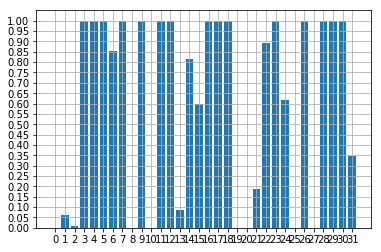

In [9]:
with tf.Session(config=config) as sess:
    saver.restore(sess, '{}/{}'.format(dir_saved_model, model_to_import))
    print("Model restored.")
        
    n1 = np.asarray([[0, 0, 0, 0, 0, 0, 0, 0]], dtype=np.float)
    n2 = np.asarray([[0, 0, 0, 0, 0, 0, 0, 0]], dtype=np.float)
    input_test = np.concatenate((n1, n2), axis=1)
    
    [predictions_value, h1_value] = sess.run(
        [predictions, h1],
        feed_dict={inputs:input_test})
    print(predictions_value)
    print(h1_value)
    print(np.squeeze(h1_value))
    
    
    x = list(range(h1_value.shape[1]))
    y = np.squeeze(h1_value)
    yticks = [0.05 * i for i in range(21)]
    plt.bar(x, y)
    plt.grid(True)
    plt.xticks(x)
    plt.yticks(yticks)
    plt.show()

## 3.3. Computing the layers and get and save their values 

In [ ]:
with tf.Session(config=config) as sess:
    saver.restore(sess, '{}/{}'.format(dir_saved_model, model_to_import))
    print("Model restored.")
    
    layers = list()
    for i1 in range(2**n_bit_input_number):
        for i2 in range(2**n_bit_input_number):
            result_dict = dict()

            n1 = np.asarray(utils.dec2bin_np_embed(i1, n_bit_input_number), dtype=np.float)
            n2 = np.asarray(utils.dec2bin_np_embed(i2, n_bit_input_number), dtype=np.float)
            input_test = np.concatenate((n1, n2), axis=1)
    
            [predictions_value, h1_value] = sess.run(
                [predictions, h1],
                feed_dict={inputs:input_test})
        
            result_dict['n1'] = n1
            result_dict['n2'] = n2
            result_dict['h1'] = h1_value
            result_dict['output'] = predictions_value
            
            layers.append(result_dict)
            
            if len(layers) % 1000 == 0:
                print(len(layers))

INFO:tensorflow:Restoring parameters from saved_models/add/mlp/20181001180511/epoch2000-batch2047.ckpt
Model restored.
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [ ]:
print(len(layers))

In [ ]:
layers[-1]

In [ ]:
layers[0]

In [ ]:
import os 

def create_dir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

In [ ]:
dir_to_save = 'data/add/layers/{}'.format(model_id)
create_dir(dir_to_save)

import pickle

with open(dir_to_save + '/layers.pickle', 'wb') as f: 
    pickle.dump(layers, f)

## 3.4. Compute the variance of activations for each digit-wise

In [ ]:
dir_to_import = 'data/add/layers/{}'.format(model_id)

import pickle

with open(dir_to_import + '/layers.pickle', 'rb') as f: 
    layers = pickle.load(f)

In [ ]:
def get_invariance_hidden_unit(layers, position, n1_digit, n2_digit):
    h1_list = list()
    for i in range(len(layers)):
        n1 = layers[i]['n1']
        n2 = layers[i]['n2']
        h1 = layers[i]['h1']
        # layers[i]['output']
        if (n1[0,-position-1], n2[0,-position-1]) == (n1_digit, n2_digit):
            h1_list.append(h1)

    h1_set = np.zeros((len(h1_list), h1_list[0].shape[1]))
    for i in range(len(h1_list)):
        h1_set[i, :] = h1_list[i]

    h1_var = np.var(h1_set, axis=0)
    return (np.min(h1_var), np.max(h1_var), np.argmin(h1_var), np.argmax(h1_var), np.argsort(h1_var), np.sort(h1_var), np.mean(h1_var))

In [ ]:
def get_mean_hidden_unit(layers, position, n1_digit, n2_digit):
    h1_list = list()
    for i in range(len(layers)):
        n1 = layers[i]['n1']
        n2 = layers[i]['n2']
        h1 = layers[i]['h1']
        # layers[i]['output']
        if (n1[0,position], n2[0,position]) == (n1_digit, n2_digit):
            h1_list.append(h1)

    h1_set = np.zeros((len(h1_list), h1_list[0].shape[1]))
    for i in range(len(h1_list)):
        h1_set[i, :] = h1_list[i]

    h1_mean = np.mean(h1_set, axis=0)
    return np.sort(h1_mean)

In [ ]:
get_invariance_hidden_unit(layers, 0, 1, 0)

In [ ]:
get_invariance_hidden_unit(layers, 0, 0, 1)

In [ ]:
n_digit_input_number = layers[0]['n1'].shape[1]
for i in range(n_digit_input_number):
    position = i
    print("position={}".format(position))
    print(get_invariance_hidden_unit(layers, position, 0, 0)[4])
    print(get_invariance_hidden_unit(layers, position, 1, 0)[4])
    print(get_invariance_hidden_unit(layers, position, 0, 1)[4])
    print(get_invariance_hidden_unit(layers, position, 1, 1)[4])

In [ ]:
print(get_invariance_hidden_unit(layers, 1, 0, 0)[4])
print(get_invariance_hidden_unit(layers, 0, 1, 0)[4])

In [ ]:
np.argsort(np.absolute(get_mean_hidden_unit(layers, 1, 0, 0) - get_mean_hidden_unit(layers, 0, 1, 0)))

The 16, 17, 18th units in the hidden layer seem to operate addition of 0 and 1 in the 1st position.

That's because the units have small variance and their mean is small difference among the inputs that give out the same output.